## 1. Import packages

In [1]:
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
import albumentations as A

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ROOT_PATH = '../lgg-mri-segmentation/kaggle_3m/'

## 2. Explore Data

### Creating DataFrame

In [2]:
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

In [3]:
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,0
1,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,0
2,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,0
3,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,1
4,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,0


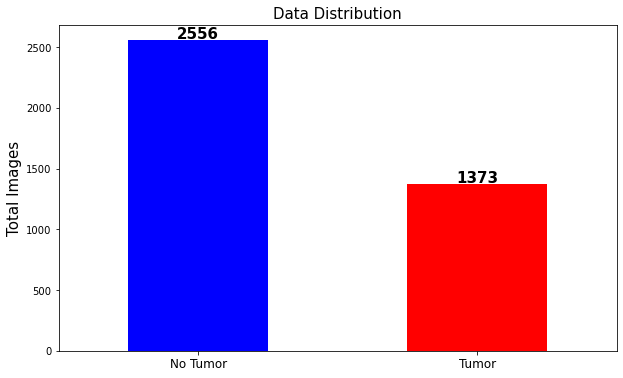

In [4]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Split data into `train`/`validation`/`test` set

In [5]:
train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15)
train_df = train_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


### Visualize Image with Mask

(-0.5, 2604.5, 520.5, -0.5)

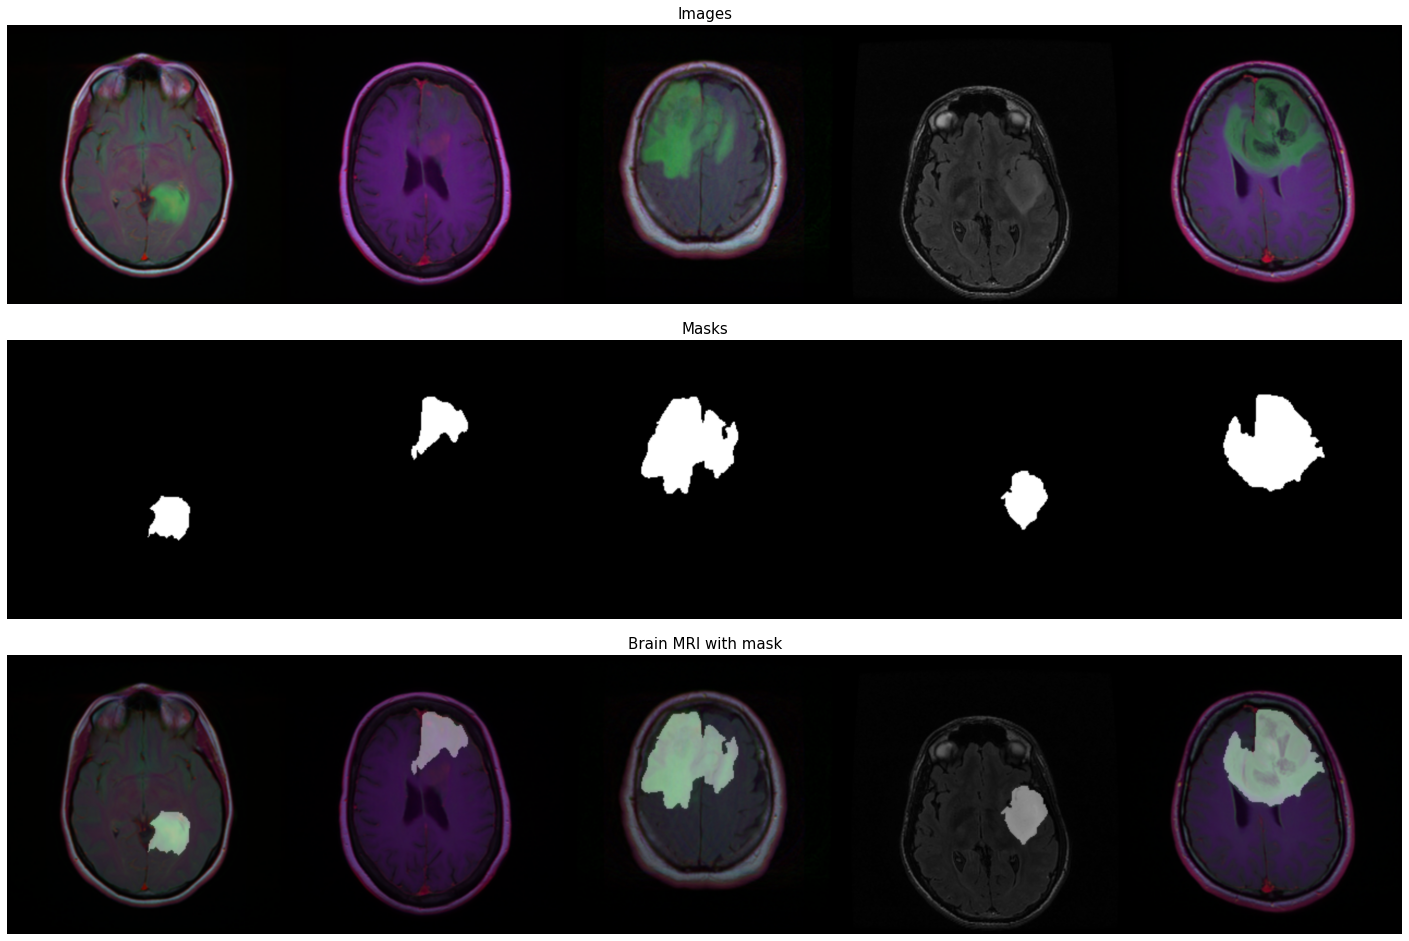

In [6]:
IMG_SIZE = 521
images = []
masks = []
df_positive = df[df['diagnosis']==1].sample(5).values
for data in df_positive:
    img = cv2.resize(cv2.imread(data[0]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(25,25))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

## 3. Data Generator and Augmentation

In [7]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i = 0
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img * std + mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img); 
        plt.axis('off')
        i += 1
    return plt.show()

## Prepare the dataset

In [10]:
from dataset import *
train_dataset, val_dataset, test_dataset = build_dataset(train_df, val_df, test_df)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=26, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=26, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=26, shuffle=False, num_workers=2)

## Build model

In [14]:
from model import build_model
model = build_model(seg_struct = 'Unet', 
                           encoder = 'timm-efficientnet-b5', 
                  decoder_channels = [256, 128, 64, 32, 16])
model = model.to(device)
out = model(torch.randn(1, 3, 256, 256).to(device))
print(out.shape)

torch.Size([1, 1, 256, 256])


## Load pretrained weight

In [15]:
state_dict = torch.load("./Unet++/best.pth", map_location='cpu')
#state_dict['model'].keys()
state_dict = state_dict['model']
model.load_state_dict(state_dict)

<All keys matched successfully>

## 5. Metric and Loss Function

In [19]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

def compute_mean_dice(model, loader, threshold=0.3):
    valloss = 0
    with torch.no_grad():
        for step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            loss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += loss

    return valloss / step

## 8. Prediction

In [20]:
test_iou = compute_mean_dice(model, test_dataloader)
print("Mean IoU: {:.3f}%".format(100*test_iou))

Mean IoU: 92.614%


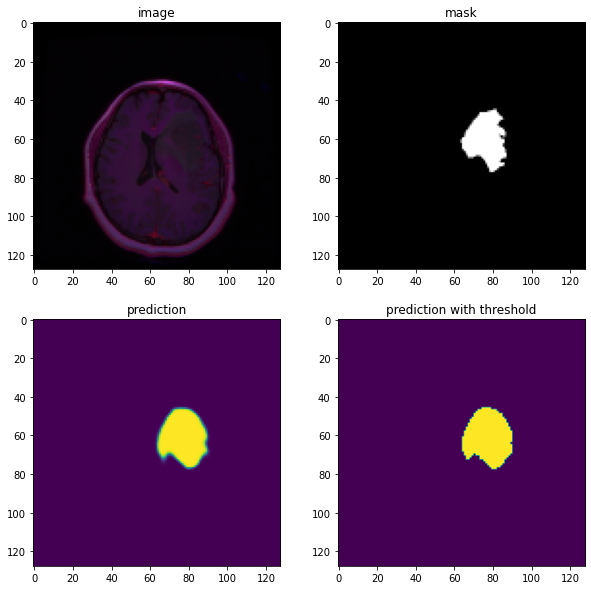

In [21]:
model.eval()
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [22]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values

def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[0]),(128, 128))
        image =  image / 255.
        ground_truth = cv2.resize(cv2.imread(test_sample[1], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(prediction)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[0]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
prediction_overlap_r = batch_preds_overlap(model, test_samples)

In [23]:
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [24]:
def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

title = "Predictions of UNet"

for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch,title, num)

In [25]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

fn = make_gif(title)

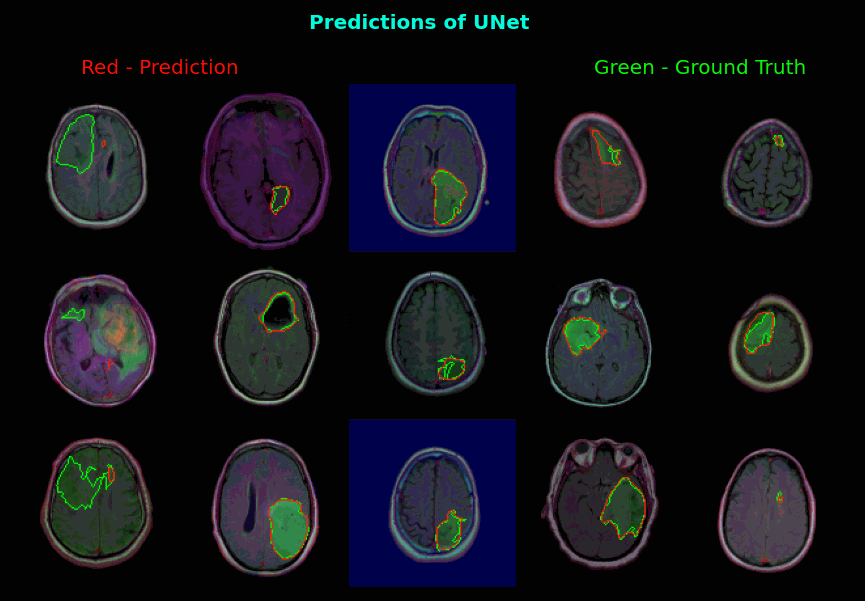

In [27]:
from IPython.display import Image as Image_display
with open(fn,'rb') as f:
    display(Image_display(data=f.read(), format='png'))